In [12]:
import pandas as pd
from pandas.io.json import loads, json_normalize

# challenge specifies to load fullVisitorId as a string to guarantee uniqueness
id_to_str = {'fullVisitorId': str}

train = pd.read_csv('./all/train.csv', dtype=id_to_str)
test  = pd.read_csv('./all/test.csv', dtype=id_to_str)

In [13]:
def parse_json_cols(df):
    for col in ['device', 'geoNetwork', 'totals', 'trafficSource']:
        # load the json and separate
        df_json = json_normalize(df[col].apply(loads), sep='/')
        df_json.columns = [(col + '/' + c) for c in df_json.columns]
        df.drop(columns=col, inplace=True)
        df = pd.concat([df, df_json], axis=1)
    return df

#
train = parse_json_cols(train)
test  = parse_json_cols(test)

---
# Examine data

### Dates are not parsed and visitStartTime is in POSIX time
    * visitStartTime makes Date redundant (more information encoded)
    * need to get continuous time data (hour, minute)

In [14]:
from datetime import datetime

def parse_dates(df):
    df['visitStartTime'] = df['visitStartTime'].apply(lambda time: datetime.fromtimestamp(time))
    df['year']  = df['visitStartTime'].dt.year
    df['month'] = df['visitStartTime'].dt.month
    df['day']   = df['visitStartTime'].dt.day
    df['dayofyear'] = df['visitStartTime'].dt.dayofyear
    df['hour']  = df['visitStartTime'].dt.hour + (df['visitStartTime'].dt.minute/60)
    df.drop(columns=['date', 'visitStartTime'], inplace=True)

    return df

#
train = parse_dates(train)
test  = parse_dates(test)

### Several columns have NaN values
* Every value in totals should have a lower bound of 0.
* Will fill remainder with most frequent value

In [15]:
nan_series = train.isna().any()
nan_true   = nan_series[nan_series == True]
nan_true

totals/bounces                                  True
totals/newVisits                                True
totals/pageviews                                True
totals/transactionRevenue                       True
trafficSource/adContent                         True
trafficSource/adwordsClickInfo/adNetworkType    True
trafficSource/adwordsClickInfo/gclId            True
trafficSource/adwordsClickInfo/isVideoAd        True
trafficSource/adwordsClickInfo/page             True
trafficSource/adwordsClickInfo/slot             True
trafficSource/campaignCode                      True
trafficSource/isTrueDirect                      True
trafficSource/keyword                           True
trafficSource/referralPath                      True
dtype: bool

In [16]:
def clean_nans(df):
    totals_cols = list(filter(lambda c : c.startswith('totals'), df.columns))
    for i in totals_cols:
        df[i] = df[i].astype(float)
        df[i].fillna(0, inplace=True)
   
    nan_series = df.isna().any()
    nan_true   = nan_series[nan_series == True]
    remaining_nan_cols = list(set(nan_true.index) - set(totals_cols))
    
    for i in remaining_nan_cols:
        # fill with most frequent value
        df[i].fillna(df[i].value_counts().index[0], inplace=True)
        
    return df

#
train = clean_nans(train)
test  = clean_nans(test)

### Several columns have 1 unique value
    * Provide no information, so will drop

In [17]:
for col in train:
    if len(train[col].unique()) == 1:
        print(col)

socialEngagementType
device/browserSize
device/browserVersion
device/flashVersion
device/language
device/mobileDeviceBranding
device/mobileDeviceInfo
device/mobileDeviceMarketingName
device/mobileDeviceModel
device/mobileInputSelector
device/operatingSystemVersion
device/screenColors
device/screenResolution
geoNetwork/cityId
geoNetwork/latitude
geoNetwork/longitude
geoNetwork/networkLocation
totals/visits
trafficSource/adwordsClickInfo/criteriaParameters
trafficSource/adwordsClickInfo/isVideoAd
trafficSource/campaignCode
trafficSource/isTrueDirect


In [18]:
def drop_single_val_cols(df):
    for col in df:
        if len(df[col].unique()) == 1:
            df.drop(columns=[col], inplace=True)
    return df

#
train = drop_single_val_cols(train)
test  = drop_single_val_cols(test)

### A lot of data is categorical
* Thinks like referal links, locations, and keywords are categorical and need to be represented as such
* Will use sklearn's LabelEncoder
    * fit on all possible values for a column, then transform

In [19]:
list(train.select_dtypes(include='object').columns)

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'device/browser',
 'device/deviceCategory',
 'device/operatingSystem',
 'geoNetwork/city',
 'geoNetwork/continent',
 'geoNetwork/country',
 'geoNetwork/metro',
 'geoNetwork/networkDomain',
 'geoNetwork/region',
 'geoNetwork/subContinent',
 'trafficSource/adContent',
 'trafficSource/adwordsClickInfo/adNetworkType',
 'trafficSource/adwordsClickInfo/gclId',
 'trafficSource/adwordsClickInfo/page',
 'trafficSource/adwordsClickInfo/slot',
 'trafficSource/campaign',
 'trafficSource/keyword',
 'trafficSource/medium',
 'trafficSource/referralPath',
 'trafficSource/source']

In [20]:
from sklearn.preprocessing import LabelEncoder

# keep an unencoded copy for visualization
unencoded_train = train.copy(deep=True)

for i in train.select_dtypes(include='object').columns:
    if i == 'fullVisitorId':
        continue

    # get list of all possible categories for each column
    all_categories = list(set(list(train[i].unique()))\
                     | set(list(test[i].unique())))

    encoder = LabelEncoder()
    # fit on column
    encoder.fit(all_categories)
    train[i] = encoder.transform(train[i])
    test[i]  = encoder.transform(test[i])

In [21]:
list(unencoded_train.select_dtypes(include='object').columns)

['channelGrouping',
 'fullVisitorId',
 'sessionId',
 'device/browser',
 'device/deviceCategory',
 'device/operatingSystem',
 'geoNetwork/city',
 'geoNetwork/continent',
 'geoNetwork/country',
 'geoNetwork/metro',
 'geoNetwork/networkDomain',
 'geoNetwork/region',
 'geoNetwork/subContinent',
 'trafficSource/adContent',
 'trafficSource/adwordsClickInfo/adNetworkType',
 'trafficSource/adwordsClickInfo/gclId',
 'trafficSource/adwordsClickInfo/page',
 'trafficSource/adwordsClickInfo/slot',
 'trafficSource/campaign',
 'trafficSource/keyword',
 'trafficSource/medium',
 'trafficSource/referralPath',
 'trafficSource/source']

### Predict natural log of revenue
* Target specified as ln(total transaction revenue + 1)
    * Need to convert transactionRevenue column to accomodate
* Evaluate with RMSE

In [22]:
from numpy import log1p

# to make the line more readable
i = 'totals/transactionRevenue'

train[i] = train[i].apply(lambda revenue: log1p(revenue))
unencoded_train[i] = unencoded_train[i].apply(lambda revenue: log1p(revenue))

# External Dataset: OECD Consumer Confidence Index

OECD - Total from Jan 2016 - Sep 2018

https://data.oecd.org/leadind/consumer-confidence-index-cci.htm#indicator-chart


* OECD (2018), Consumer confidence index (CCI) (indicator). doi: 10.1787/46434d78-en (Accessed on 11 October 2018)

In [23]:
def add_cci(df):
    cci = pd.read_csv('./all/oecd_total_cci.csv', index_col=0)
    cci_dict = cci.to_dict()['Value']
    df['year-month']  = df['year'].astype(str) + '-' + df['month'].astype(str)
    
    df['cci'] = df['year-month'].map(cci_dict)
    df['cci'].fillna(df['cci'].median(), inplace=True)
    
    df.drop(columns=['year-month'], inplace=True)
    return df

train = add_cci(train)
test  = add_cci(test)
unencoded_train = add_cci(unencoded_train)

#### Save Preprocessed DataFrames

In [24]:
train.to_csv('./all/p_train.csv', index=False)
test.to_csv('./all/p_test.csv', index=False)
unencoded_train.to_csv('./all/unencoded_train.csv', index=False)

---
---
---
# Load Preprocessed DataFrames

In [49]:
import pandas as pd

id_to_str = {'fullVisitorId': str}

train = pd.read_csv('./all/p_train.csv', dtype=id_to_str)
test  = pd.read_csv('./all/p_test.csv', dtype=id_to_str)
unencoded_train = pd.read_csv('./all/unencoded_train.csv', dtype=id_to_str)

---
# Visualize

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

%matplotlib inline

In [71]:
unencoded_train['trafficSource/adwordsClickInfo/page'].describe()

count     903653
unique         8
top            1
freq      903555
Name: trafficSource/adwordsClickInfo/page, dtype: object

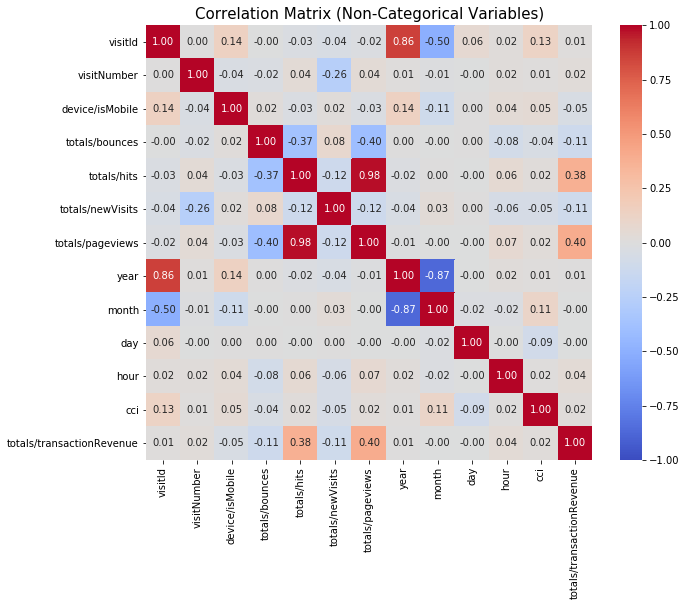

In [72]:
no_cats = unencoded_train.select_dtypes(exclude='object')

i = 'totals/transactionRevenue'
columns = list(no_cats.columns)
columns.remove(i); columns.append(i)

no_cats = no_cats[columns]

no_cats_corr = no_cats.corr()
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix (Non-Categorical Variables)', fontsize=15)
sns.heatmap(no_cats_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1, 
            cbar_kws=dict(ticks=list(np.arange(-1.0, 1.1, 0.25))), fmt='.2f')
plt.show()

In [73]:
no_cats.corr()['totals/transactionRevenue'].sort_values(ascending=False)

totals/transactionRevenue    1.000000
totals/pageviews             0.400732
totals/hits                  0.378804
hour                         0.040587
visitNumber                  0.023666
cci                          0.016590
visitId                      0.010491
year                         0.007604
day                         -0.000860
month                       -0.002693
device/isMobile             -0.046071
totals/newVisits            -0.108003
totals/bounces              -0.113049
Name: totals/transactionRevenue, dtype: float64

---
### The majority of paying customers will view the site under 30 times.

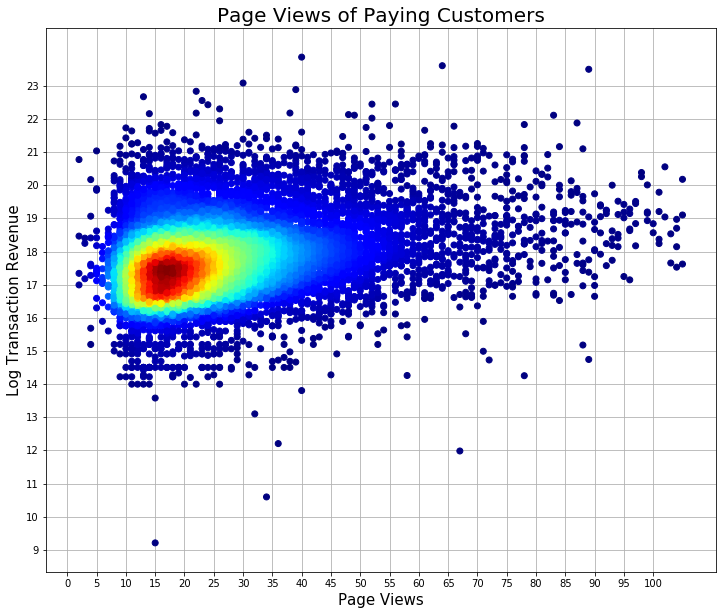

In [8]:
pv_tr = train[train['totals/transactionRevenue'] > 0]
p_99 = np.percentile(pv_tr['totals/pageviews'].sort_values(), 99)
pv_tr = pv_tr[pv_tr['totals/pageviews'] < p_99]

x_values = pv_tr['totals/pageviews']
y_values = pv_tr['totals/transactionRevenue']

xy = np.vstack([x_values, y_values]); 
density = gaussian_kde(xy)(xy)

plt.figure(figsize=(12, 10)); plt.title('Page Views of Paying Customers', fontsize=20)
plt.xticks(np.arange(0, x_values.max(), step=5)); plt.yticks(np.arange(0, y_values.max(), step=1))
plt.xlabel('Page Views', fontsize=15); plt.ylabel('Log Transaction Revenue', fontsize=15)
plt.scatter(x_values, y_values, alpha=1, c=density, cmap='jet')
#plt.colorbar(ticks=[], aspect=50).set_label('Relative Density', fontsize=20)
plt.grid(True)
plt.show()

---
### Referalls bring in the most page views and the most revenue

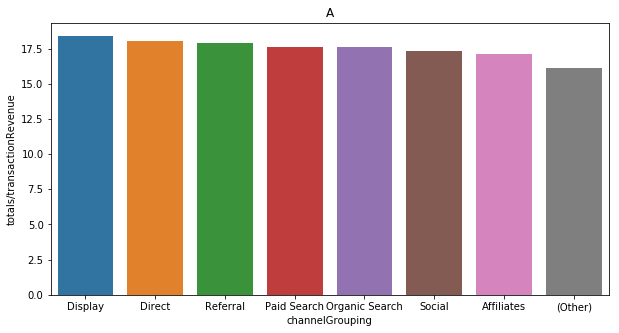

In [65]:
browser_rev = unencoded_train[['totals/transactionRevenue', 'channelGrouping']]
browser_rev = browser_rev[browser_rev['totals/transactionRevenue'] > 0]
browser_rev = browser_rev.groupby('channelGrouping').mean()
browser_rev = browser_rev.sort_values(by='totals/transactionRevenue', ascending=False)
x = browser_rev.index
y = browser_rev['totals/transactionRevenue']
plt.figure(figsize=(10, 5))
sns.barplot(x, y).set_title('A')
plt.show()

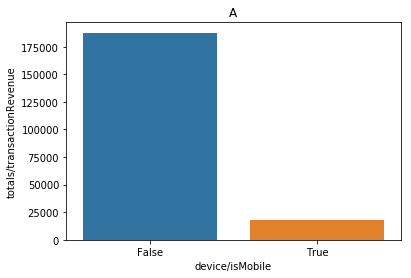

In [38]:
mobile_revenue = train[['totals/transactionRevenue', 'device/isMobile']]
mobile_revenue = mobile_revenue.groupby('device/isMobile').sum()
x = mobile_revenue.index
y = mobile_revenue['totals/transactionRevenue']
sns.barplot(x, y).set_title('A')
plt.show()

In [88]:
unencoded_train['month'].value_counts()

11    113935
10     97286
12     79458
8      77307
7      71782
9      71103
3      69924
4      67148
5      65336
1      64634
6      63565
2      62175
Name: month, dtype: int64

In [38]:
unencoded_train['channelGrouping'].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

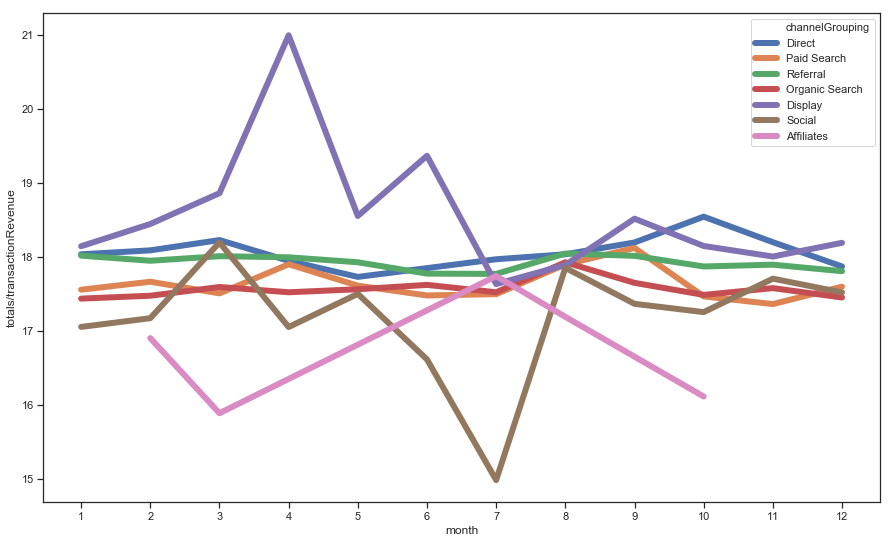

In [87]:
channels = unencoded_train[['channelGrouping', 'totals/transactionRevenue', 'month']]
channels = unencoded_train[unencoded_train['totals/transactionRevenue'] > 0]
channels = channels[channels['channelGrouping'] != '(Other)']

plt.figure(figsize=(15,9))
plt.xticks(np.arange(0, 12+1, step=1))
channels = channels.sort_values(by='month')

sns.set(style="ticks", rc={"lines.linewidth": 6})
sns.lineplot('month', 'totals/transactionRevenue', data=channels, err_style=None,  hue='channelGrouping')
plt.show()

---
# Train models

In [ ]:
def get_tt_split(df):
    X = df.drop(columns=['totals/transactionRevenue', 'fullVisitorId'])
    y = df['totals/transactionRevenue']
    
    return train_test_split(X, y, test_size = 0.1, random_state = 3)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import clip

def train_lr(df):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    model = LinearRegression()
    print('Training model: {0}...\n'.format('lr'))
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    test_predictions = clip(test_predictions, a_min=0, a_max=None)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    print('=====')
    print('RMSE:', rmse)
    print('=====\n\n==========')
    print('INTERCEPT:', model.intercept_)
    print('==========\n\n==========================')
    print('COEFFICIENTS (decreasing):')
    print('==========================')
    coefficients = list(zip(X_test.columns, model.coef_))
    coefficients.sort(key = lambda c: c[1])
    for i in coefficients[::-1]:
        print('{0}:\n\t{1}\n'.format(i[0], i[1]))
    
    
    return model

In [ ]:
lr_model = train_lr(train)

In [ ]:
import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from numpy import clip

def train_xgb(df):
    X_train, X_test, y_train, y_test = get_tt_split(df)
    
    print('Training model: {0}...'.format('xgb'))
    model = xgb.train({'eta':0.6}, DMatrix(X_train, y_train))
    test_predictions = model.predict(DMatrix(X_test))
    test_predictions = clip(test_predictions, a_min=0, a_max=None)
    
    mse = mean_squared_error(y_test, test_predictions)
    rmse = sqrt(mse)
    
    print('=====')
    print('RMSE:', rmse)
    return model

In [ ]:
xgb_model = train_xgb(train)

---
# Specify model

In [ ]:
selected_model = 'xgb'

# Create Submission

In [ ]:
X_test = test.drop(columns=['fullVisitorId'])

if selected_model == 'lr':
    model = train_lr(train)
elif selected_model == 'xgb':
    model = train_xgb(train)
    X_test = DMatrix(X_test)

real_predictions = model.predict(X_test)
real_predictions = clip(real_predictions, a_min=0, a_max=None)

real_df = test['fullVisitorId'].to_frame()
real_df['PredictedLogRevenue'] = real_predictions
real_df['fullVisitorId'] = real_df['fullVisitorId'].astype('str')
real_df = real_df.groupby('fullVisitorId').sum()
real_df.to_csv('submission.csv')